## Testing Collation for WMH Challenge preprocessing

The collated files should consist of one numpy file for each domain (note that Amsterdam is split into 3 domains)
Each file should contain, flair, t1, wmh and ID (it's fold, domain, number string, so that I can easily identify each individual instance. Nice.

The challenge data is actually a bunch of different shapes, so I am not sure if I should
collate the images....
I think what I need to do is calculate the minimum size that contains the brain across all the images and then crop to that, as opposed to what I am currently doing... that would at least be consistent, but I need to deal with the issue that I'm not sure that the resampling code is working...


### okay the three things that I need to try and fix now
- [ ] not happy with how the normalization is being done (the cutoff and the dark bits that are appearing around the mask....). Okay I should redo the normalization to use the training data only nice.
- [ ] not sure what that first slice is in my preprocessed images
- [x] not sure that the resampling is being done correctly given the large slice disparities... (yes the brain is in a similar size region actually, so it looks fine).
- [x] calculate the actual height width and depth of each brain (and then crop the image to centre it with a couple of slices each side. Nice.

In [9]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from tqdm import tqdm
from ulw_data.preprocessing.WMH_Chal_file_parser import get_files_dict

In [44]:
norm = "_norm10" # [_norm02, _norm05, _norm10, '']
preprocessed_path = f"/media/benp/NVMEspare/datasets/full_WMH_Chal_dataset{norm}/preprocessed/individual_files"
ds_path = f"/media/benp/NVMEspare/datasets/full_WMH_Chal_dataset"
collated_path = f"/media/benp/NVMEspare/datasets/full_WMH_Chal_dataset{norm}/preprocessed/collated"

In [45]:
flair = f'{preprocessed_path}/training_Amsterdam_GE3T_100_FLAIR.nii.gz'

In [46]:
flair = nib.load(flair)

In [47]:
flair.shape

(158, 250, 83)

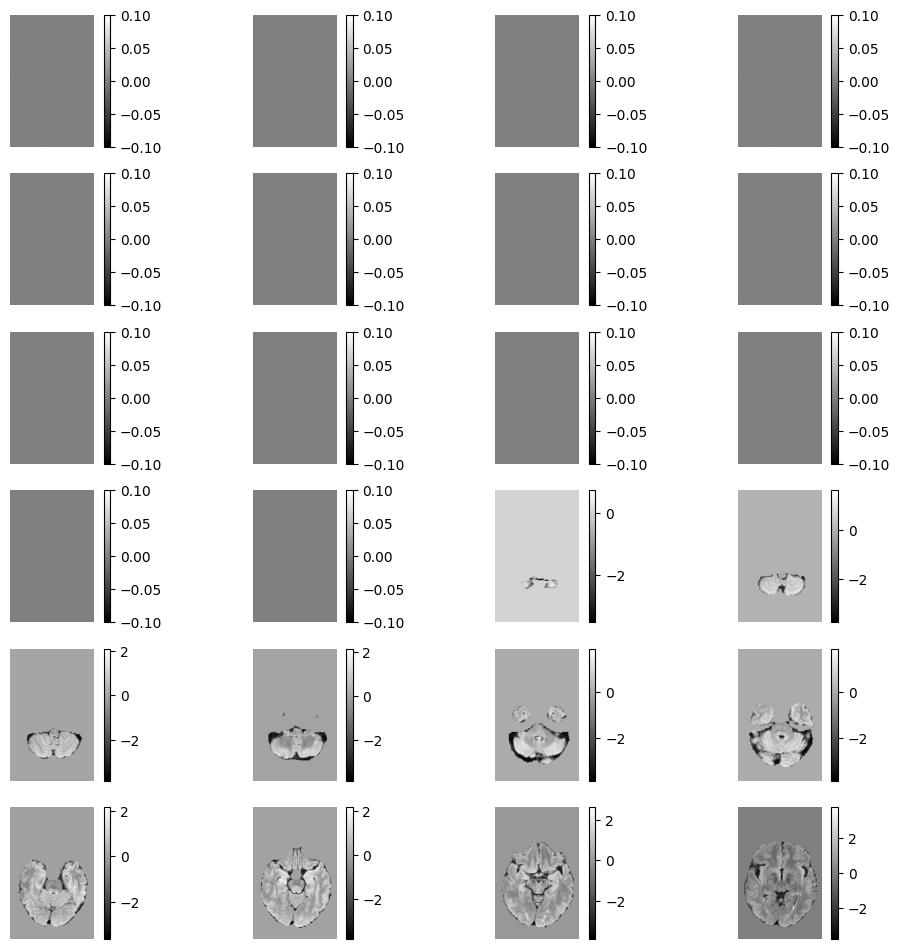

In [48]:
plt.figure(figsize=(12, 12))
for i in range(24):
    plt.subplot(6, 4, i+1)
    plt.imshow(flair.get_fdata()[:,:,i*2].swapaxes(0,1), cmap='gray')#, vmin=-3, vmax=3)
    plt.colorbar()
    plt.axis('off')

In [49]:
files = os.listdir(preprocessed_path)

In [50]:
files_dict = get_files_dict(ds_path, preprocessed_path)

In [51]:
#files_dict

In [52]:
files_dict['training_Amsterdam_GE3T_100']

{'FLAIR': '/media/benp/NVMEspare/datasets/full_WMH_Chal_dataset/training/Amsterdam_GE3T/100/pre/FLAIR.nii.gz',
 'T1': '/media/benp/NVMEspare/datasets/full_WMH_Chal_dataset/training/Amsterdam_GE3T/100/pre/T1.nii.gz',
 'wmh': '/media/benp/NVMEspare/datasets/full_WMH_Chal_dataset/training/Amsterdam_GE3T/100/wmh.nii.gz',
 'fold': 'training',
 'domain': 'Amsterdam_GE3T',
 'id': '100',
 'out_path': '/media/benp/NVMEspare/datasets/full_WMH_Chal_dataset_norm10/preprocessed/individual_files/training_Amsterdam_GE3T_100'}

In [53]:
# split up each entry by it's domain and its fold (training or test)
files_dict_items_by_domain = defaultdict(lambda: {})
for key, entry in files_dict.items():
    files_dict_items_by_domain[f"{entry['domain']}_{entry['fold']}"][key] = entry

In [54]:
files_dict_items_by_domain.keys()

dict_keys(['Amsterdam_GE3T_training', 'Singapore_training', 'Utrecht_training', 'Amsterdam_GE3T_test', 'Singapore_test', 'Utrecht_test', 'Amsterdam_GE1T5_test', 'Amsterdam_Philips_VU_PETMR_01_test'])

In [55]:
# for each domain, load all of the relevant data, and make a combined file.
# I will turn the files for the separate channels into a single array, so its
# flair, mask, t1, wmh (I think). or I could do flair, mask, t1 as one and wmh as a separate.
# the array index will be the name of the file....

In [56]:
def load_data(subject_entry):
    subject_path = subject_entry['out_path'] + '_'
    flair = subject_path + 'FLAIR.nii.gz'
    t1 = subject_path + 'T1.nii.gz'
    mask = subject_path + 'mask.nii.gz'
    wmh = subject_path + 'wmh.nii.gz'

    flair = nib.load(flair).get_fdata()
    t1 = nib.load(t1).get_fdata()
    mask = nib.load(mask).get_fdata()
    wmh = nib.load(wmh).get_fdata()

    #print(subject_path, flair.shape, t1.shape, mask.shape, wmh.shape)

    data = np.stack([flair, t1, mask, wmh], axis=0)

    return data

In [57]:
collated_path

'/media/benp/NVMEspare/datasets/full_WMH_Chal_dataset_norm10/preprocessed/collated'

In [58]:
try:
    os.makedirs(collated_path)
except FileExistsError:
    print("Warning: collation folder already exists. Continuing")

In [59]:
def calculate_dim_pad(arr_size, target_size):
    assert target_size > arr_size

    diff = target_size - arr_size
    if diff % 2 == 0:
        pad = (diff//2, diff//2)
    else:
        pad = (diff//2, diff//2+1)

    return pad

In [60]:
def crop_and_pad_brain(image, out_shape=[192,224,64]):
    # channels are: flair, t1, mask, wmh.
    mask = image[2]
    brain_locs = np.where(mask)

    # crop
    image = image[
        :,
        brain_locs[0].min():brain_locs[0].max(),
        brain_locs[1].min():brain_locs[1].max(),
        brain_locs[2].min():brain_locs[2].max(),    
    ]

    # pad
    shape = image.shape
    pad0 = calculate_dim_pad(shape[1], out_shape[0])
    pad1 = calculate_dim_pad(shape[2], out_shape[1])
    pad2 = calculate_dim_pad(shape[3], out_shape[2])
    image = np.pad(image, ((0,0),pad0, pad1, pad2))

    return image

In [61]:
max_dim0 = 0
max_dim1 = 0
max_dim2 = 0

for domain, domain_entries in files_dict_items_by_domain.items():
    domain_data = []
    domain_ids = []
    print(f"processing files from {domain}")
    # load the data
    for subject_id, entry in tqdm(domain_entries.items(), position=0, leave=True):
        domain_data.append(load_data(entry))
        domain_ids.append(subject_id)
    #     print(entry)
    #     break
    # break

    for data in domain_data:
        result = np.where(data[2])
        
        # calcuate the shape of that brain
        range0 = (-result[0].min()+result[0].max())
        range1 = (-result[1].min()+result[1].max())
        range2 = (-result[2].min()+result[2].max())
        print(data.shape, range0, range1, range2)
        max_dim0 = range0 if range0 > max_dim0 else max_dim0
        max_dim1 = range1 if range1 > max_dim1 else max_dim1
        max_dim2 = range2 if range2 > max_dim2 else max_dim2

    domain_data = [crop_and_pad_brain(data, out_shape=[192,224,64]) for data in tqdm(domain_data, position=0, leave=True)]
    np.savez_compressed(
        file=f'{collated_path}{os.path.sep}{domain}.npz',
        args=domain_data,
        kwds=domain_ids
    )

processing files from Amsterdam_GE3T_training


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.93it/s]


(4, 158, 250, 83) 137 164 41
(4, 158, 250, 83) 152 167 48
(4, 158, 250, 83) 130 170 42
(4, 158, 250, 83) 141 164 43
(4, 158, 250, 83) 151 176 45
(4, 158, 250, 83) 145 166 44
(4, 158, 250, 83) 141 162 42
(4, 158, 250, 83) 135 161 39
(4, 158, 250, 83) 126 171 41
(4, 158, 250, 83) 149 181 46
(4, 158, 250, 83) 149 170 46
(4, 158, 250, 83) 134 163 42
(4, 158, 250, 83) 140 172 43
(4, 158, 250, 83) 139 165 42
(4, 158, 250, 83) 134 173 44
(4, 158, 250, 83) 138 164 41
(4, 158, 250, 83) 155 180 43
(4, 158, 250, 83) 128 170 44
(4, 158, 250, 83) 139 168 41
(4, 158, 250, 83) 124 174 44


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.22it/s]


processing files from Singapore_training


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.17it/s]


(4, 256, 232, 48) 134 159 42
(4, 256, 232, 48) 127 156 43
(4, 232, 256, 48) 129 155 40
(4, 232, 256, 48) 142 153 41
(4, 232, 256, 48) 136 160 45
(4, 232, 256, 48) 139 157 43
(4, 232, 256, 48) 125 160 42
(4, 232, 256, 48) 133 154 40
(4, 232, 256, 48) 131 167 46
(4, 232, 256, 48) 127 166 44
(4, 232, 256, 48) 143 157 44
(4, 232, 256, 48) 139 154 43
(4, 232, 256, 48) 136 159 46
(4, 232, 256, 48) 128 171 43
(4, 232, 256, 48) 140 156 45
(4, 232, 256, 48) 134 163 45
(4, 232, 256, 48) 143 161 44
(4, 232, 256, 48) 129 151 41
(4, 232, 256, 48) 135 149 41
(4, 232, 256, 48) 134 168 43


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.79it/s]


processing files from Utrecht_training


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.49it/s]


(4, 230, 230, 48) 145 180 44
(4, 230, 230, 48) 134 172 41
(4, 230, 230, 48) 144 167 44
(4, 230, 230, 48) 126 158 44
(4, 230, 230, 48) 135 170 40
(4, 230, 230, 48) 141 180 45
(4, 230, 230, 48) 140 173 38
(4, 230, 230, 48) 142 182 41
(4, 230, 230, 48) 131 161 41
(4, 230, 230, 48) 140 171 44
(4, 230, 230, 48) 132 174 38
(4, 230, 230, 48) 126 166 42
(4, 230, 230, 48) 133 163 40
(4, 230, 230, 48) 136 166 39
(4, 230, 230, 48) 138 173 40
(4, 230, 230, 48) 128 162 37
(4, 230, 230, 48) 134 168 40
(4, 230, 230, 48) 132 163 38
(4, 230, 230, 48) 132 176 44
(4, 230, 230, 48) 130 172 43


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.20it/s]


processing files from Amsterdam_GE3T_test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.40it/s]


(4, 158, 250, 83) 130 167 41
(4, 158, 250, 83) 144 169 44
(4, 158, 250, 83) 136 171 44
(4, 158, 250, 83) 139 169 44
(4, 158, 250, 83) 140 166 43
(4, 158, 250, 83) 135 168 43
(4, 158, 250, 83) 136 161 44
(4, 158, 250, 83) 141 168 46
(4, 158, 250, 83) 140 180 45
(4, 158, 250, 83) 126 163 39
(4, 158, 250, 83) 130 154 50
(4, 158, 250, 83) 148 166 47
(4, 158, 250, 83) 141 170 43
(4, 158, 250, 83) 137 164 43
(4, 158, 250, 83) 130 161 41
(4, 158, 250, 83) 137 165 44
(4, 158, 250, 83) 136 179 44
(4, 158, 250, 83) 130 174 42
(4, 158, 250, 83) 139 169 42
(4, 158, 250, 83) 144 174 43
(4, 158, 250, 83) 132 175 42
(4, 158, 250, 83) 135 165 43
(4, 158, 250, 83) 132 175 43
(4, 158, 250, 83) 149 163 49
(4, 158, 250, 83) 129 166 41
(4, 158, 250, 83) 131 156 40
(4, 158, 250, 83) 134 165 46
(4, 168, 250, 83) 136 168 41
(4, 149, 250, 83) 135 172 41
(4, 163, 250, 83) 133 168 43


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.91it/s]


processing files from Singapore_test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.38it/s]


(4, 232, 256, 48) 148 162 44
(4, 232, 256, 48) 135 173 41
(4, 232, 256, 48) 147 165 45
(4, 232, 256, 48) 134 154 42
(4, 232, 256, 48) 141 162 44
(4, 232, 256, 48) 132 161 43
(4, 232, 256, 48) 138 156 42
(4, 232, 256, 48) 135 168 44
(4, 232, 256, 48) 131 161 45
(4, 232, 256, 48) 130 161 42
(4, 232, 256, 48) 136 161 41
(4, 232, 256, 48) 142 161 44
(4, 232, 256, 48) 131 147 41
(4, 232, 256, 48) 147 173 44
(4, 232, 256, 48) 142 154 47
(4, 232, 256, 48) 133 169 45
(4, 232, 256, 48) 125 159 43
(4, 232, 256, 48) 142 159 40
(4, 232, 256, 48) 129 150 41
(4, 232, 256, 48) 133 161 44
(4, 232, 256, 48) 134 148 41
(4, 232, 256, 48) 129 147 38
(4, 232, 256, 48) 140 161 43
(4, 232, 256, 48) 140 177 47
(4, 232, 256, 48) 126 158 45
(4, 232, 256, 48) 134 168 45
(4, 232, 256, 48) 133 179 46
(4, 232, 256, 48) 138 162 44
(4, 232, 256, 48) 130 155 42
(4, 232, 256, 48) 132 154 43


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 15.39it/s]


processing files from Utrecht_test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  9.31it/s]


(4, 230, 230, 48) 130 172 38
(4, 230, 230, 48) 127 167 41
(4, 230, 230, 48) 127 172 40
(4, 230, 230, 48) 132 172 42
(4, 230, 230, 48) 131 162 38
(4, 230, 230, 48) 138 161 44
(4, 230, 230, 48) 133 184 43
(4, 230, 230, 48) 134 168 41
(4, 230, 230, 48) 132 167 38
(4, 230, 230, 48) 137 171 43
(4, 230, 230, 48) 127 170 45
(4, 230, 230, 48) 133 175 41
(4, 230, 230, 48) 128 152 42
(4, 230, 230, 48) 144 176 44
(4, 230, 230, 48) 130 168 40
(4, 230, 230, 48) 141 151 39
(4, 230, 230, 48) 138 163 40
(4, 230, 230, 48) 131 158 40
(4, 230, 230, 48) 142 166 41
(4, 230, 230, 48) 148 169 42
(4, 230, 230, 48) 137 165 39
(4, 230, 230, 48) 139 171 44
(4, 230, 230, 48) 135 171 39
(4, 230, 230, 48) 135 171 40
(4, 230, 230, 48) 137 184 44
(4, 230, 230, 48) 146 173 45
(4, 230, 230, 48) 133 159 42
(4, 230, 230, 48) 131 176 43
(4, 230, 230, 48) 125 169 40
(4, 230, 230, 48) 139 183 43


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.90it/s]


processing files from Amsterdam_GE1T5_test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.65it/s]


(4, 166, 310, 103) 128 156 44
(4, 166, 310, 103) 137 164 41
(4, 166, 310, 103) 127 163 41
(4, 166, 310, 103) 142 178 40
(4, 166, 310, 103) 135 167 44
(4, 166, 310, 103) 141 184 45
(4, 166, 310, 103) 136 167 45
(4, 161, 310, 103) 131 151 40
(4, 161, 310, 103) 128 155 39
(4, 161, 310, 103) 145 173 48


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.56it/s]


processing files from Amsterdam_Philips_VU_PETMR_01_test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.18it/s]


(4, 180, 250, 83) 143 191 44
(4, 180, 250, 83) 141 174 43
(4, 180, 250, 83) 125 159 41
(4, 180, 250, 83) 128 158 45
(4, 180, 250, 83) 132 153 45
(4, 180, 250, 83) 123 155 46
(4, 180, 250, 83) 138 166 46
(4, 180, 250, 83) 130 169 44
(4, 180, 250, 83) 131 169 46
(4, 180, 250, 83) 148 173 53


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.66it/s]


In [118]:
max_dim0, max_dim1, max_dim2

(155, 191, 53)

In [ ]:
# the max dimension sizes for a brain in each dimension is 155, 191, 53. So actually these images are not so big.
# What I can do is take a section of 
# 192, 224, 64 where each brain is centered in that range. I pick that size as it has a convinent patch size for treating the whole image. Nice.
# okay so the easiest thing to do is crop to the brain mask and then pad up to the 192, 224, 64 range. Nice.

In [119]:
def calculate_dim_pad(arr_size, target_size):
    assert target_size > arr_size

    diff = target_size - arr_size
    if diff % 2 == 0:
        pad = (diff//2, diff//2)
    else:
        pad = (diff//2, diff//2+1)

    return pad

In [124]:
def crop_and_pad_brain(image, out_shape=[192,224,64]):
    # channels are: flair, t1, mask, wmh.
    mask = image[2]
    brain_locs = np.where(mask)

    # crop
    image = image[
        :,
        brain_locs[0].min():brain_locs[0].max(),
        brain_locs[1].min():brain_locs[1].max(),
        brain_locs[2].min():brain_locs[2].max(),    
    ]

    # pad
    shape = image.shape
    pad0 = calculate_dim_pad(shape[1], out_shape[0])
    pad1 = calculate_dim_pad(shape[2], out_shape[1])
    pad2 = calculate_dim_pad(shape[3], out_shape[2])
    image = np.pad(image, ((0,0),pad0, pad1, pad2))

    return image
    

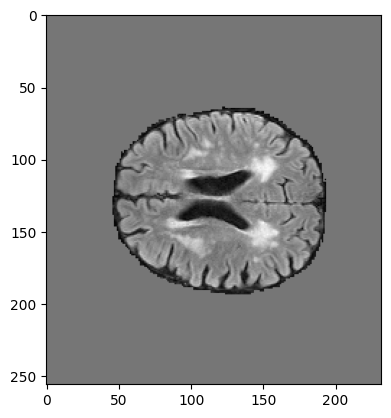

In [129]:
plt.imshow(domain_data[0][0,:,:,29], cmap='gray')

In [ ]:
# is this resampling code correct? I'm not sure because these 103 channel images must be over double the size of the
# 48 channel images. Like the brain itself should be contained within just 48 slices... So I'm a little confused by this and I'm not sure
# that the resampling code is working correctly. hmm...

In [128]:
for domain, domain_entries in files_dict_items_by_domain.items():
    domain_data = []
    domain_ids = []
    print(f"processing files from {domain}")
    # load the data
    for subject_id, entry in tqdm(domain_entries.items(), position=0, leave=True):
        domain_data.append(load_data(entry))
        domain_ids.append(subject_id)

    # crop and pad each image
    domain_data = [crop_and_pad_brain(data, out_shape=[192,224,64]) for data in domain_data]

    # calculate the range of the mask bounds for each image...
    
    np.savez_compressed(
        file=f'{collated_path}{os.path.sep}{domain}.npz',
        args=domain_data,
        kwds=domain_ids
    )

processing files from Amsterdam_GE3T_training


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.80it/s]


processing files from Singapore_training


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.88it/s]


processing files from Utrecht_training


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.43it/s]


processing files from Amsterdam_GE3T_test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  9.17it/s]


processing files from Singapore_test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  9.85it/s]


processing files from Utrecht_test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 10.48it/s]


processing files from Amsterdam_GE1T5_test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.01it/s]


processing files from Amsterdam_Philips_VU_PETMR_01_test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.38it/s]


In [129]:
# test the arrays that I have saved
arr = np.load(f'{collated_path}{os.path.sep}{"Utrecht_training"}.npz')

In [141]:
args = arr['args']

In [143]:
args.shape

(20, 4, 192, 224, 64)

In [135]:
keys = arr['kwds']

In [137]:
from natsort import natsorted

In [138]:
natsorted(keys) # yeah natsorted works on the array. Nice.

['training_Utrecht_0',
 'training_Utrecht_2',
 'training_Utrecht_4',
 'training_Utrecht_6',
 'training_Utrecht_8',
 'training_Utrecht_11',
 'training_Utrecht_17',
 'training_Utrecht_19',
 'training_Utrecht_21',
 'training_Utrecht_23',
 'training_Utrecht_25',
 'training_Utrecht_27',
 'training_Utrecht_29',
 'training_Utrecht_31',
 'training_Utrecht_33',
 'training_Utrecht_35',
 'training_Utrecht_37',
 'training_Utrecht_39',
 'training_Utrecht_41',
 'training_Utrecht_49']

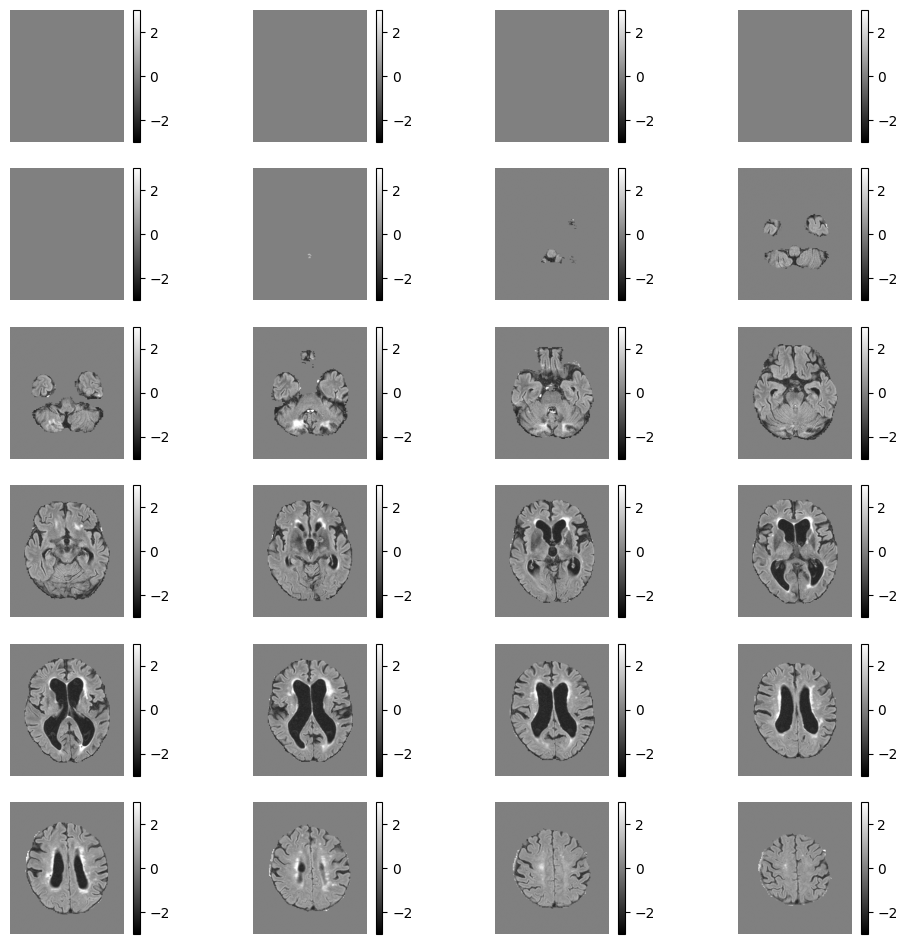

In [151]:
plt.figure(figsize=(12, 12))
for i in range(24):
    plt.subplot(6, 4, i+1)
    plt.imshow(args[0,0,:,:,i*2].swapaxes(0,1), cmap='gray', vmin=-3, vmax=3)
    plt.colorbar()
    plt.axis('off')

In [144]:
args[0,:,:,i*2].shape

(4, 192, 64)